In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [3]:
# Yves Acremann, 16.5.2021

## Kalman filtering of the sine:

For the algoritym we follow https://en.wikipedia.org/wiki/Extended_Kalman_filter
We use the "standard" names of matrices according to the Wikipedia page. However, for simplification the variables after the prediction step are marked with a tilde.

The state: $X = \begin{pmatrix} \phi \\ \omega \\ A \end{pmatrix}$

Observable: $m_k = h(X_k) + v_k= A_k \sin{\phi_k} + v_k$

$v_k$ is the measurement noise.

### Taylor expansion:

Observable:
\begin{equation}
H_{i,j} = \frac{\partial h_i(X)}{\partial X_j} = (A \cos \phi, 0,\sin \phi)
\end{equation}

Transition:
\begin{equation}
F = \begin{pmatrix} 1 & \Delta t & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1\end{pmatrix}
\end{equation}

### Prediction:

$\tilde{X} = F X$

Predicted covariance estimate: $\tilde{P} = FP_{k-1|k-1}F^T + Q_k$.

$Q_k$ is the covariance of the process (which turns out to be essential!). We assume it is diagonal. Further, we assume $P$ has the form

$P = \begin{pmatrix}
    P_0    & P_{od} & 0 \\
    P_{od} & P_1    & 0 \\
    0      & 0      & P_2
\end{pmatrix}$

This results in:
$\tilde{P} = \begin{pmatrix} 
    P_0+2\Delta t P_{od}+\Delta t^2 P_1 & P_{od}+P_1 \Delta t & 0 \\
    P_{od}+\Delta t P_1       & P_1          & 0 \\
    0                  & 0            & P_2
\end{pmatrix} + Q =: 
\begin{pmatrix}
    \tilde{P}_0    & \tilde{P}_{od} & 0 \\
    \tilde{P}_{od} & \tilde{P}_1    & 0 \\
    0              & 0              & \tilde{P}_3
\end{pmatrix}
$






### Update:
Innovation or measurement residual: ${\tilde  {y}}= z_k - \tilde{A} \sin \tilde{\phi}$

Innovation (or residual) covariance: $S = \tilde{P}_0 \tilde{A}^2 \cos^2 \tilde{\phi} + \tilde{P}_2 \sin^2 \tilde{\phi} + R =: \alpha + R$

Gain: $K = \frac{1}{S} 
\begin{pmatrix}
    \tilde{P}_0 \tilde{A} \cos \tilde{\phi} \\
    \tilde{P}_{od} \tilde{A} \cos \tilde{\phi} \\
    \tilde{P}_2 \sin \tilde{\phi}
\end{pmatrix}$

Updated state estimate: $X = \tilde{X} + K \tilde{y}$

Update covarience estimage: $P = (1-K H) \tilde{P} = (1-\frac{\alpha}{\alpha+R})\tilde{P}$

Here, we only take the diagonal components of P to close the loop.

## Initlal values and constants EKF

In [4]:
# estimated phase:
phi_0 = 0 #1.1

# estimated frequency:
lambda_hene = 632.8e-9 #m
v_stage = 0.005 #m per sec
hene_freq = v_stage*2/lambda_hene
print(hene_freq)

omega_0 = 2*np.pi*hene_freq # rad/s

# estimated amplitude
A_0 = 0.012#2.0 # V

# Variance of the measurement:
R = 0.000001

#Sampling frequency
fs=250e3

# time step:
DeltaT = 1/fs # s__

# The error of the estimation process (must be >0!)
# This parameter needs some experimenting, depending on how fast the physical parameters change.

# estimated phase covariance:
n_phi_0 = 0.01

# estimated frequency covariance:
n_omega_0 = 0.0001

# estimated amplitude covariance:
n_A_0 = 0.0001

n_od_0 = 0

ProcessError = np.array([n_phi_0, n_omega_0, n_A_0, n_od_0])
print(omega_0)
print(DeltaT)

15802.781289506953
99291.80321080257
4e-06


## EKF functions:

In [5]:
# Predict functions:
def predict_state(state):
    return(np.array([state[0]+DeltaT*state[1], state[1], state[2]]))

""" We return fist all diagonal terms and then the off-diagonal element. """
def predict_P(P):
    P_0 = P[0] + 2*DeltaT*P[3] + DeltaT**2*P[1] + ProcessError[0]
    P_1 = P[1] + ProcessError[1]
    P_2 = P[2] + ProcessError[2]
    P_od = P[3] + DeltaT*P[1] + ProcessError[3]
    return(np.array([P_0, P_1, P_2, P_od]))

In [6]:
# Update functions:
def alpha(state, P):
#     print(P[0]*(state[2]**2)*(np.cos(state[0]))**2 + P[2]*(np.sin(state[0]))**2)
    return (P[0]*(state[2]**2)*(np.cos(state[0]))**2 + P[2]*(np.sin(state[0]))**2)

def gain(state, P):
    s = (alpha(state, P) + R)
    K_0 = P[0]*state[2]*np.cos(state[0])
    K_1 = P[3]*state[2]*np.cos(state[0])
    K_2 = P[2]*np.sin(state[0])
    return(np.array([K_0, K_1, K_2])/s)

def update_state(state, P, measurement):
    y = measurement - state[2]*np.sin(state[0])
    return (state + y*gain(state,P)), y*gain(state,P)

def update_P(state, P):
    a = alpha(state, P) #.astype(int)
    return (1-a/(a+R))*P,(1-a/(a+R)) #np.floor(

## Testsignal generation

<IPython.core.display.Javascript object>


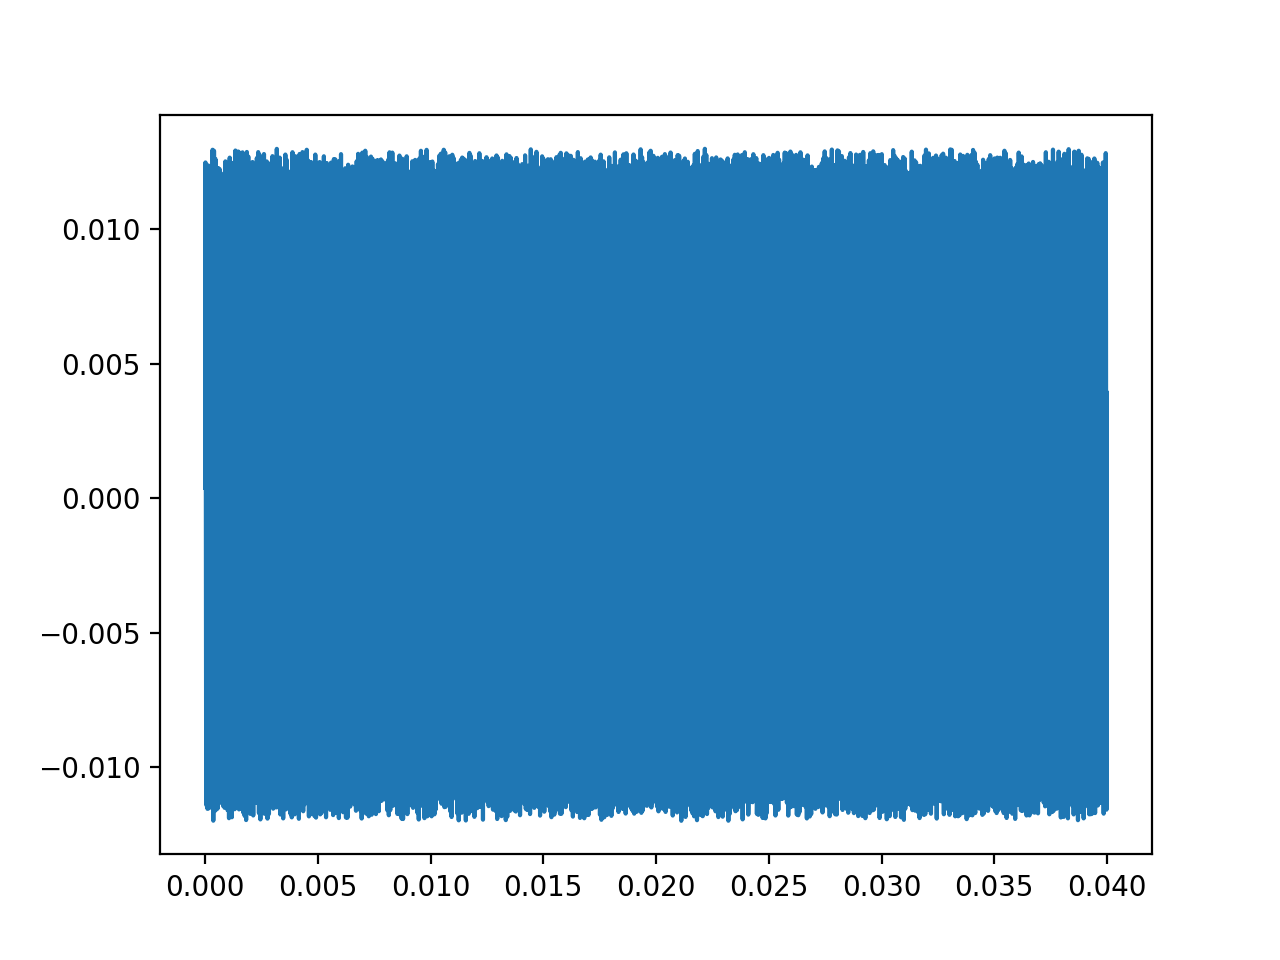

In [9]:
times = np.arange(0, 10000*DeltaT, DeltaT)
# A noisy, frequency and amplitude modulated signal
omega_real = omega_0
A_real = A_0
R_real = R
omega_mod = np.sin(times*omega_real/11)
amplitude_mod = np.cos(times*omega_real/7)*0.25*A_real
signalPhase = times*(omega_real)  # + omega_mod
noise = (np.random.rand(len(times)))*np.sqrt(R_real)
offset = 0
# signal = np.load('signal.npy')
signal = (A_real)*np.sin(signalPhase) + noise # + offset + amplitude_mod
plt.figure()
plt.plot(times, signal)
plt.show()

## Real Signal

<IPython.core.display.Javascript object>


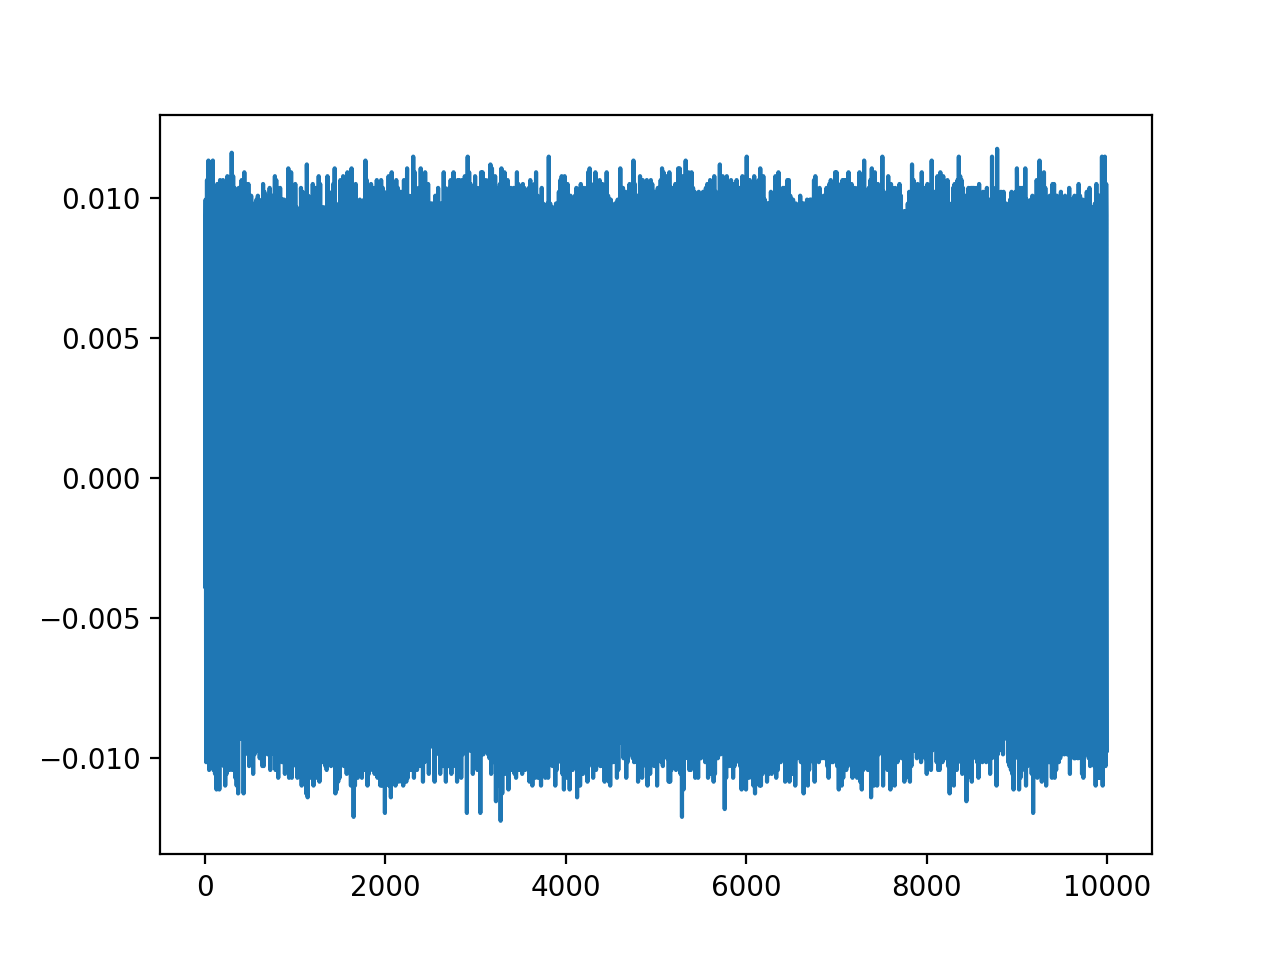

In [10]:
hene = np.load('../KalmanCPU/data/hene.npy') # (2, 16Mil)
hene = hene[:10001]
plt.figure()
# plt.plot(hene[0,:], hene[1,:])
plt.plot(hene[:])
plt.show()
# print('Sampling time')
# print((hene[0,999]-hene[0,0])/1000)
# print('Sampling freq')
# print(1000/(hene[0,999]-hene[0,0]))

In [11]:
import time
import torch
# hene = np.load('../KalmanCPU/data/hene.npy')
# mct = np.load('../KalmanCPU/data/mct.npy')
# resampled = np.load('../KalmanCPU/data/resampled.npy')
lasers = np.load('lasers.npy', allow_pickle=True).item()
mct = lasers["MCT"]
hene = lasers["HeNe"]

## ZC detection post process

1.6192986965179443


<IPython.core.display.Javascript object>


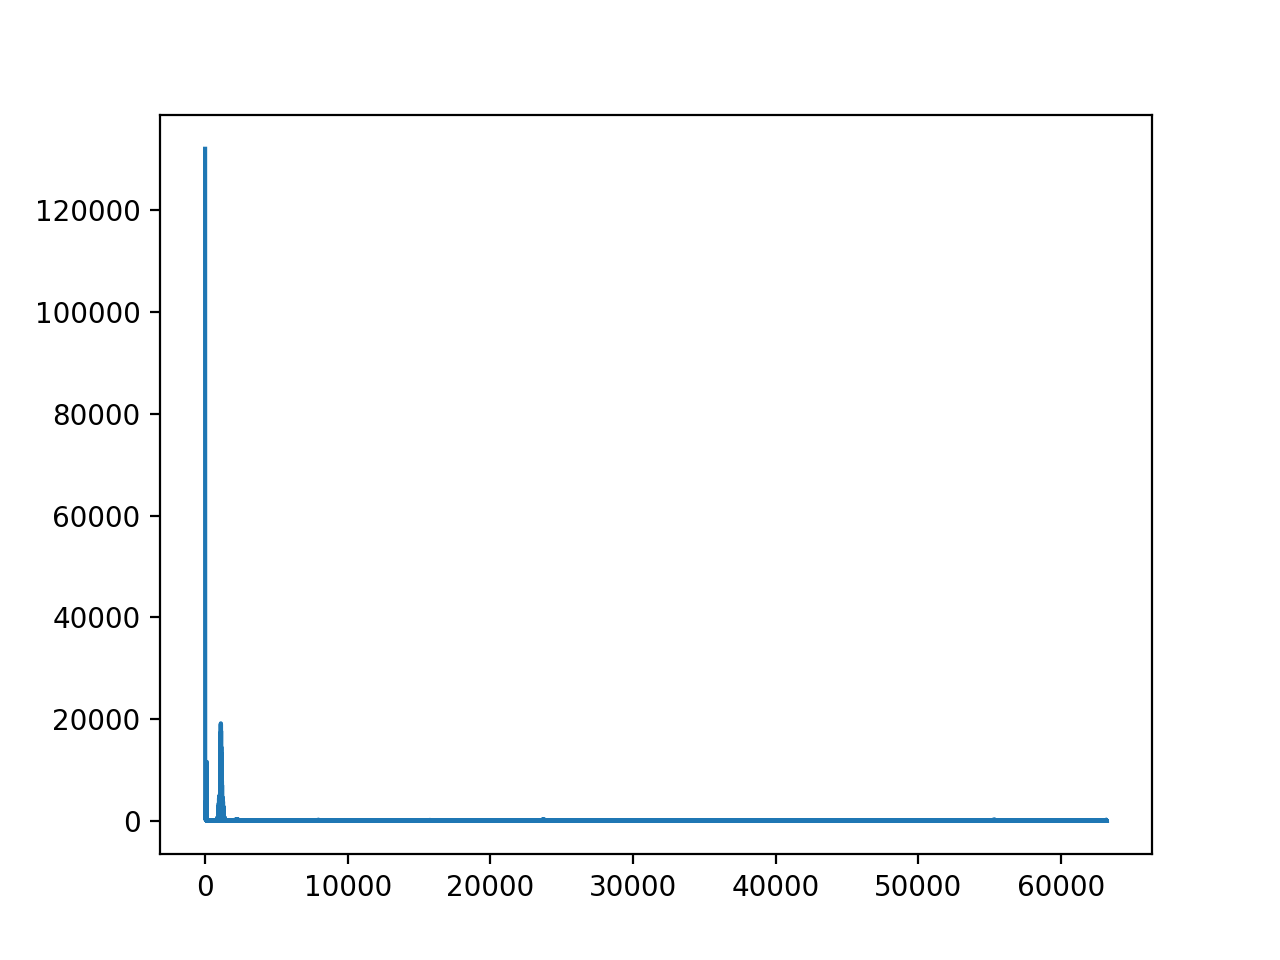

In [12]:
start = time.time()
hene = hene - np.mean(hene)
zero_crosses = np.where(np.diff(np.sign(hene)))[0]
fft = np.abs(np.fft.rfft(mct[zero_crosses]))
print(time.time()-start)
fig = plt.figure()
plt.plot(np.fft.rfftfreq(len(mct), d=lambda_hene*100/8), np.abs(np.fft.rfft(mct)))
plt.show()


In [13]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(hene, linestyle='none', marker='.')
# ax.plot(zero_crosses, np.zeros(len(zero_crosses)), 'rx', markersize=10)
# plt.title('Post Process ZC on Hene')
# plt.show()

In [14]:
# plt.figure()
# plt.plot(mct)
# plt.title('Original Signal')
# plt.show()

## Kalman Filter Realtime

<IPython.core.display.Javascript object>


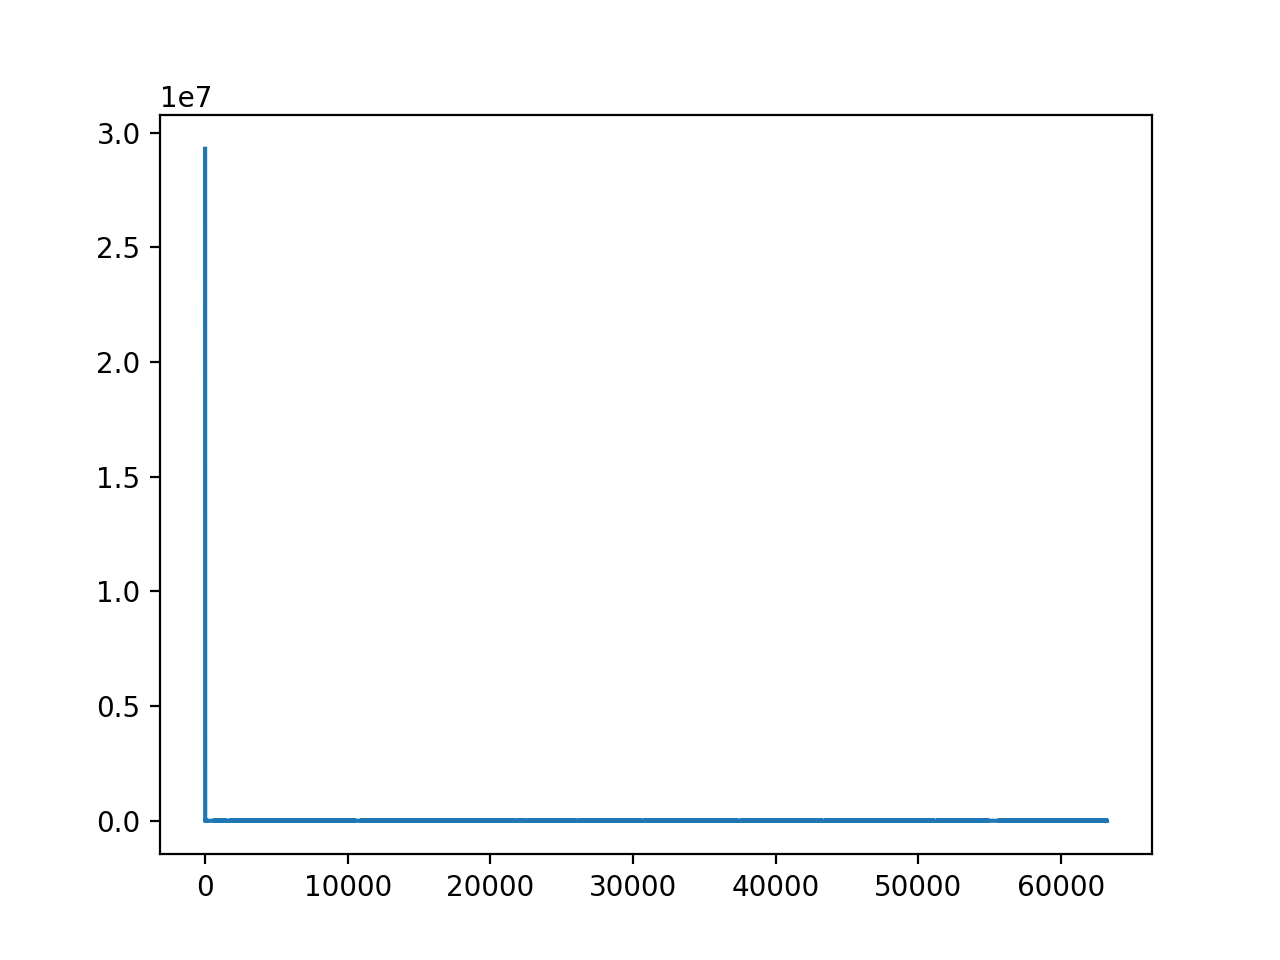

In [15]:
hene = np.load('../KalmanCPU/data/hene.npy')
mct = np.load('../KalmanCPU/data/mct.npy')
resampled = np.load('../KalmanCPU/data/resampled.npy')
fig = plt.figure()
plt.plot(np.fft.rfftfreq(len(resampled), d=lambda_hene*100/8),np.abs(np.fft.rfft(resampled)))
plt.show()

<IPython.core.display.Javascript object>


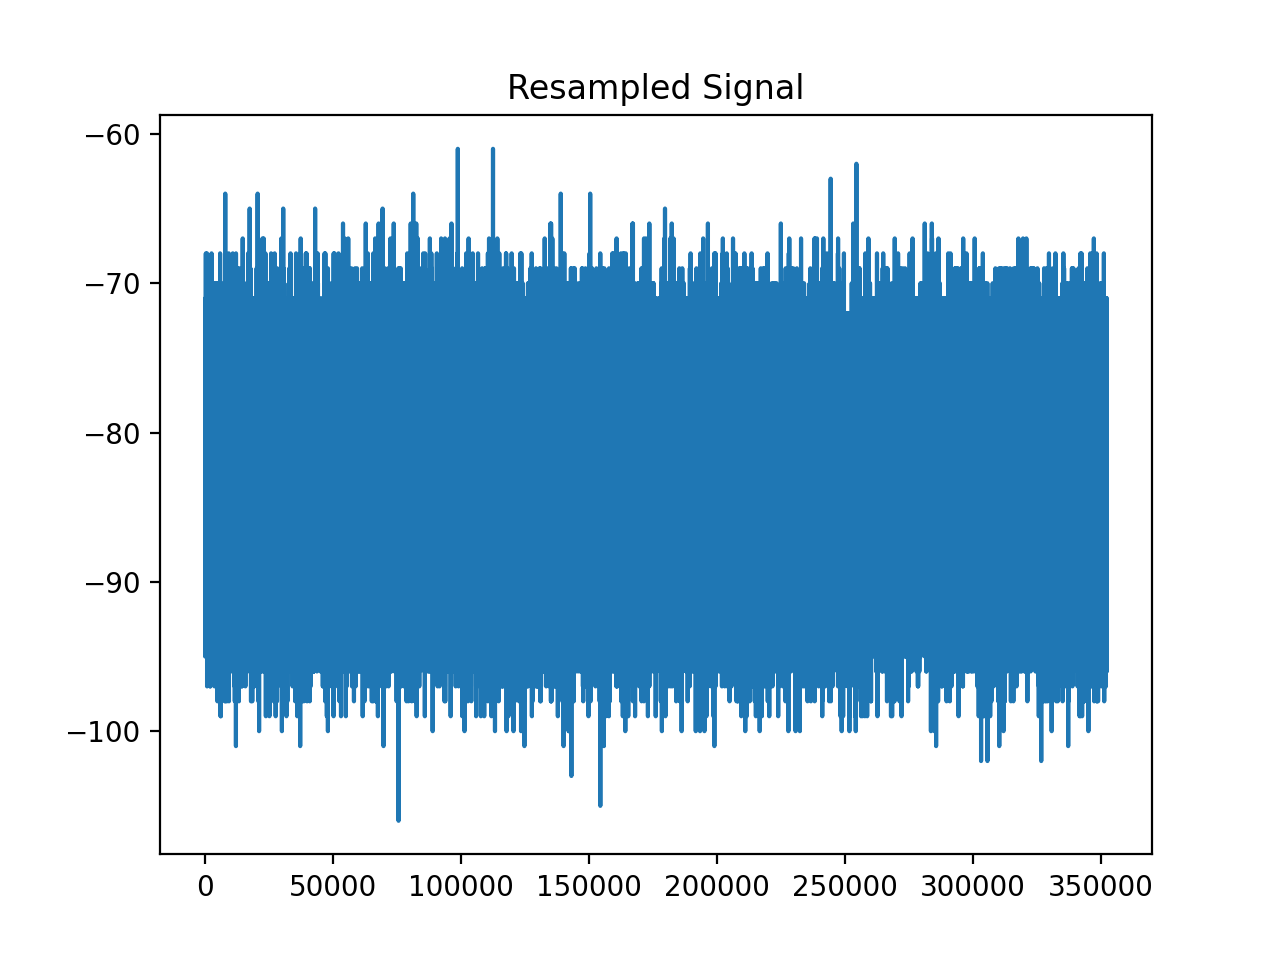

In [16]:
plt.figure()
plt.plot(resampled)
plt.title('Resampled Signal')
plt.show()

In [17]:
print(len(hene))
print(len(mct))
print(len(resampled))

688128
688128
352426


<IPython.core.display.Javascript object>


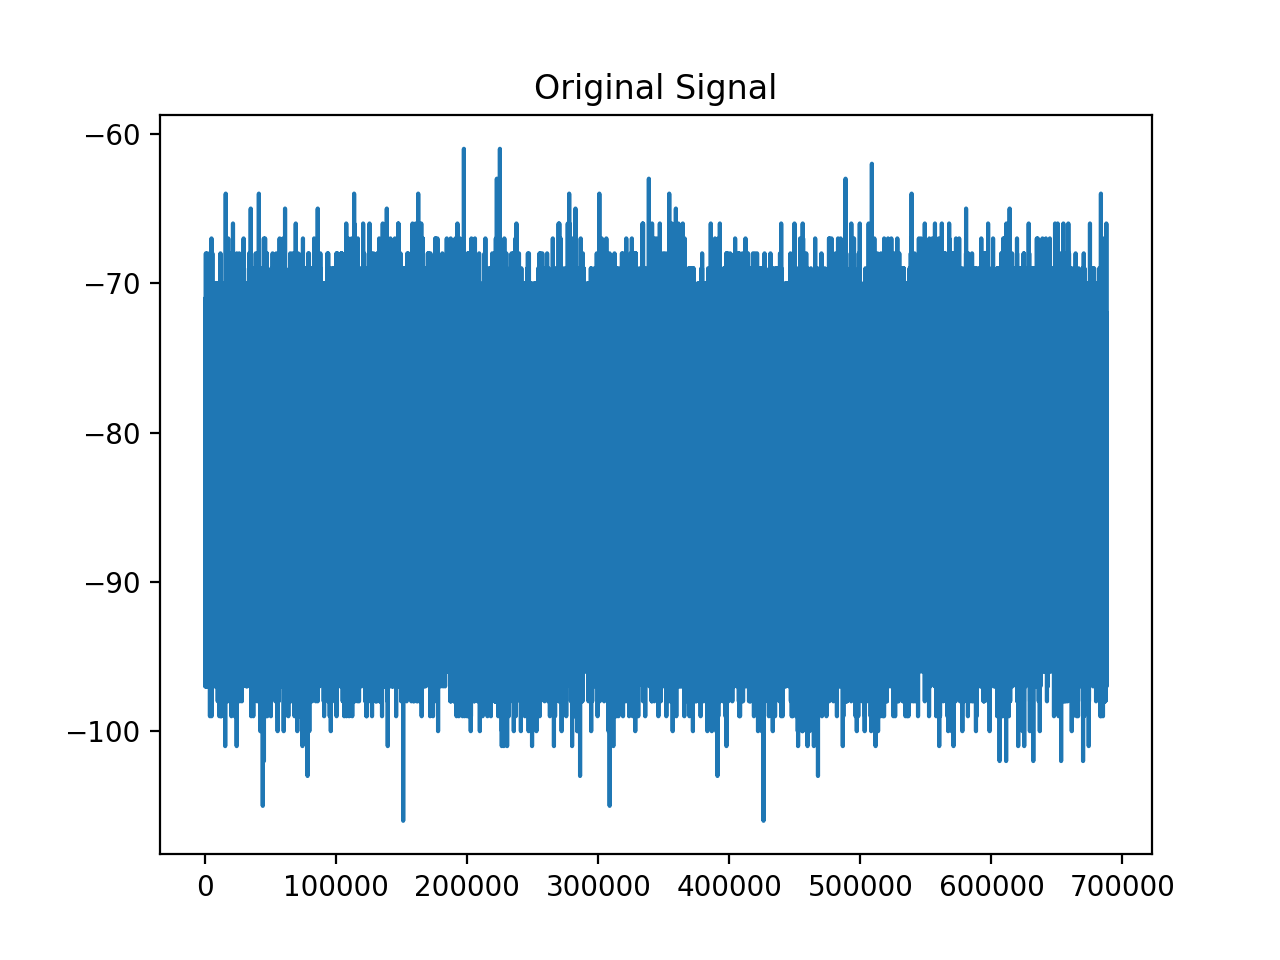

In [18]:
plt.figure()
plt.plot(mct)
plt.title('Original Signal')
plt.show()

## Now let's try to filter it...

In [20]:
import pdb
result = np.zeros(len(times))
phase = np.zeros(len(times))
pred_zc = np.zeros(len(times))
cov = np.zeros([4,len(times)])
ampl = np.zeros(len(times))
# ctrl = np.zeros(len(times))
ctrl = np.zeros([3,len(times)])
freq = np.zeros(len(times))

# initial values for X and P
X = np.array([phi_0, omega_0, A_0])
# P = np.array([n_phi_0, n_omega_0, n_A_0, n_od_0])
P = np.array([100, 100, 100, 100])
half_phase=0
signal = hene # [1,:]
# Iterate through all time stess
for i in range(0, len(times)):
    # prediction:
    X_tilde = predict_state(X)
    P_tilde = predict_P(P)
    # update:
    X,y = update_state(X_tilde, P_tilde, signal[i])
    P,_ = update_P(X_tilde, P_tilde)
    
    # Make phase 
    if(X[0]>2*np.pi):
        X[0] = X[0] - 2*np.pi
    if(X[0]>np.pi):
        half_phase = 0
    else:
        half_phase = 1
    
    
    # just store results for plotting:
    result[i] = X[2]*np.sin(X[0])
    phase[i]  = X[0]
    freq[i] = X[1]
    ampl[i] = X[2]
    pred_zc[i] = half_phase
    cov[:,i] = P_tilde
    ctrl[:,i] = y

<IPython.core.display.Javascript object>


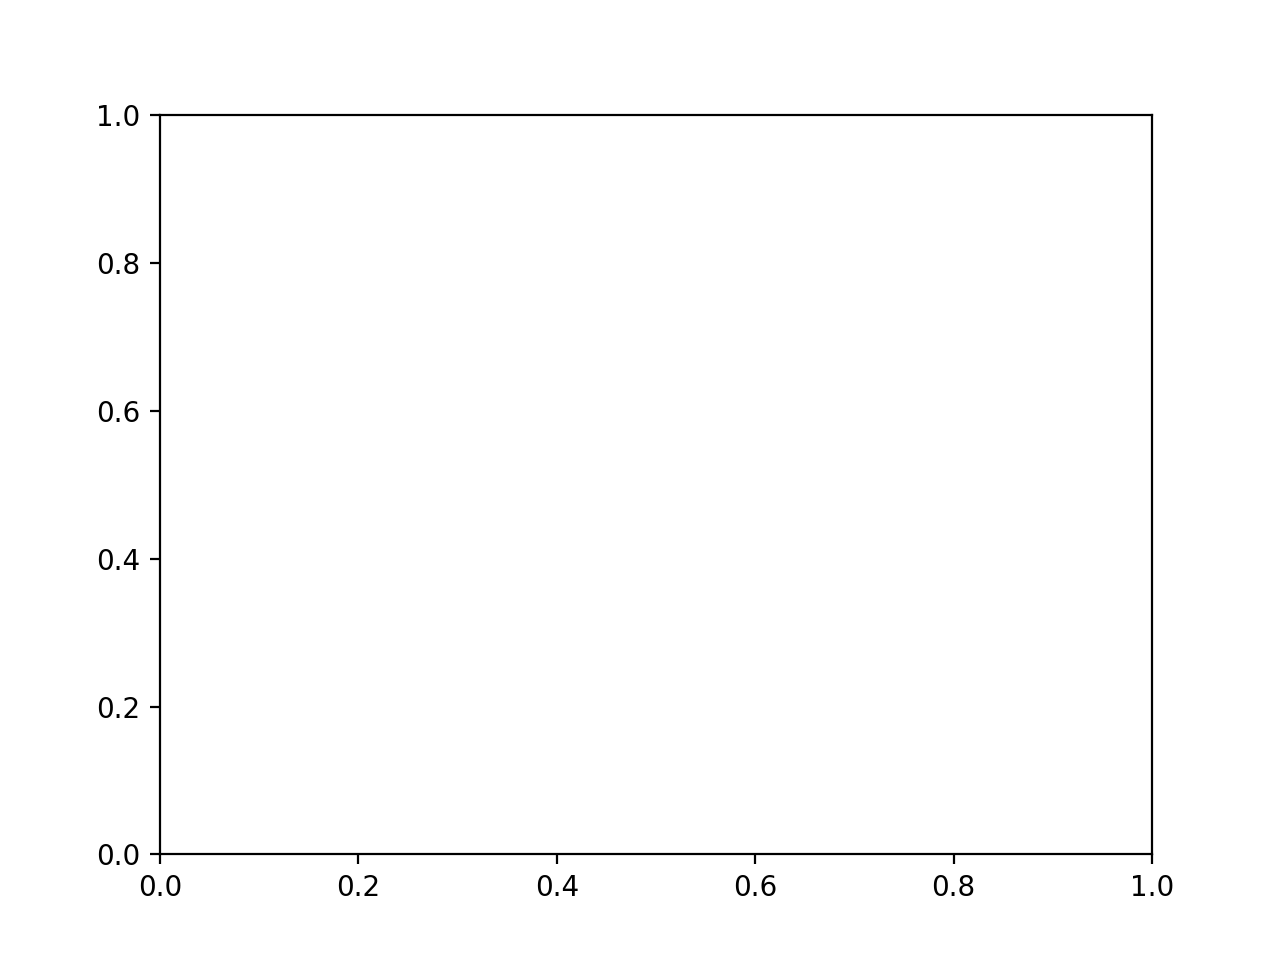

ValueError: x and y must have same first dimension, but have shapes (10000,) and (688128,)

In [21]:
plt.figure()
ax1 = plt.gca()
#ax2 = ax1.twinx()
ax1.plot(times, signal, label='signal')
ax1.plot(times, result, label='result')
# ax1.plot(times[:-1], np.diff(phase % np.pi))
ax1.plot(times, pred_zc*np.max(signal)*0.9, label='halfphase')
# ax2.plot(times[:-1],np.diff(phase % np.pi), '.')
# ax2.plot(times,phase % 2**16)
# ax2.plot(times,freq, 'k')
# ax2.hlines(np.pi*np.arange(10), times[0], times[-1])
ax1.legend()
plt.show()

<IPython.core.display.Javascript object>


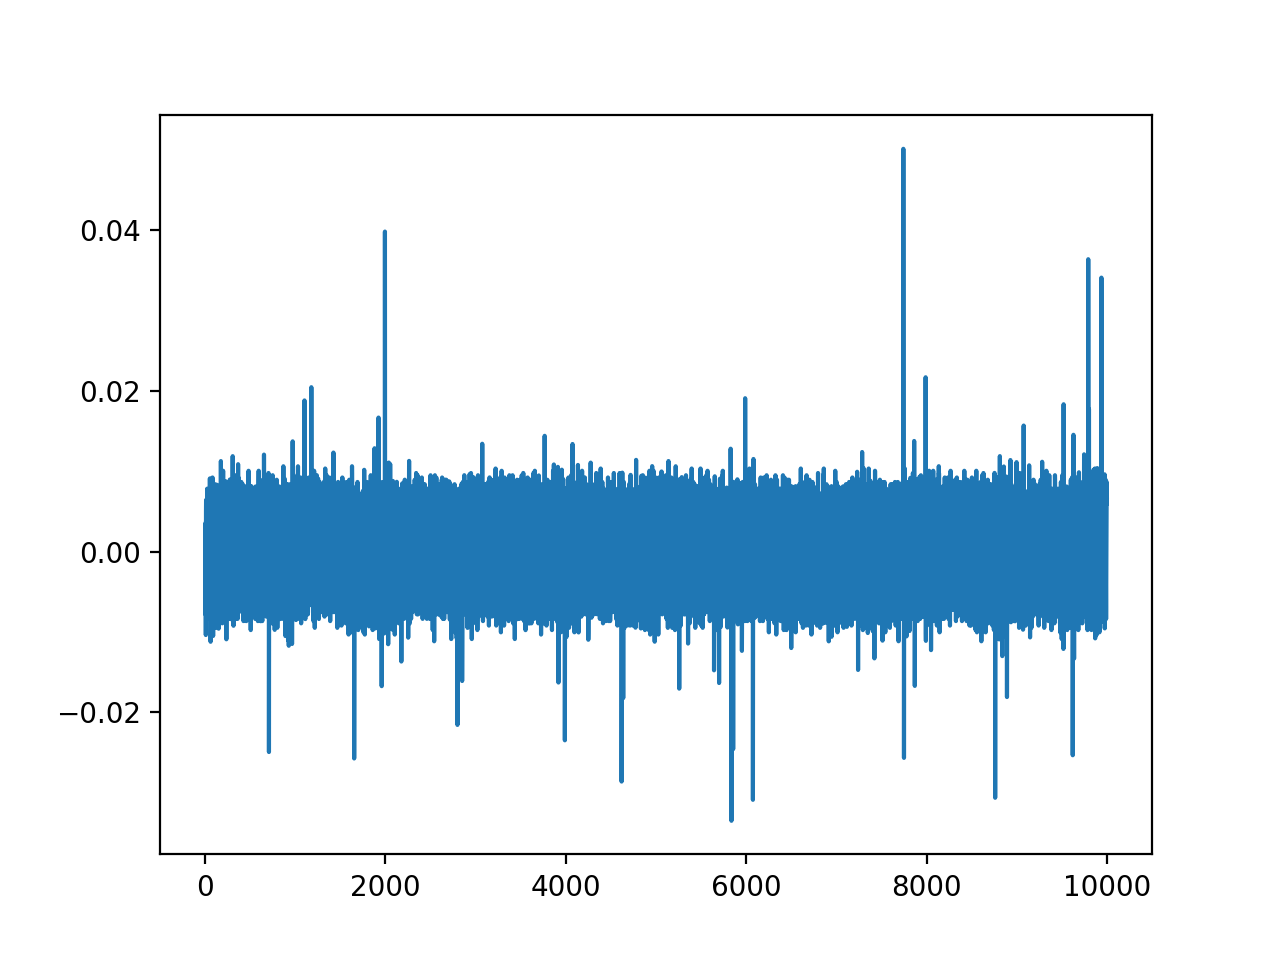

In [83]:
plt.figure()
plt.plot(result)
plt.show()

<IPython.core.display.Javascript object>


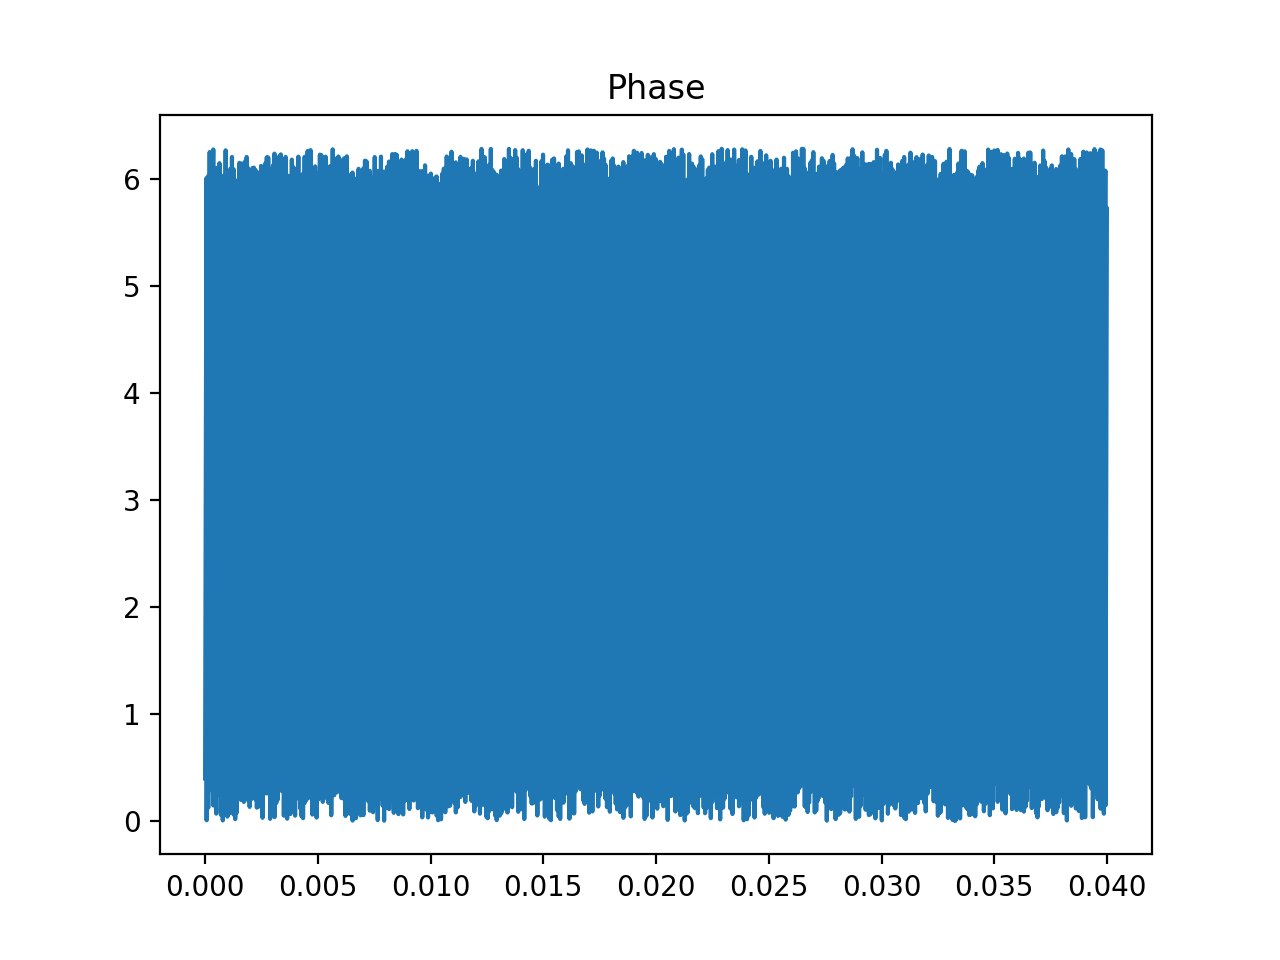

In [84]:
plt.figure()
plt.plot(times, phase)
plt.title('Phase')
plt.show()

<IPython.core.display.Javascript object>


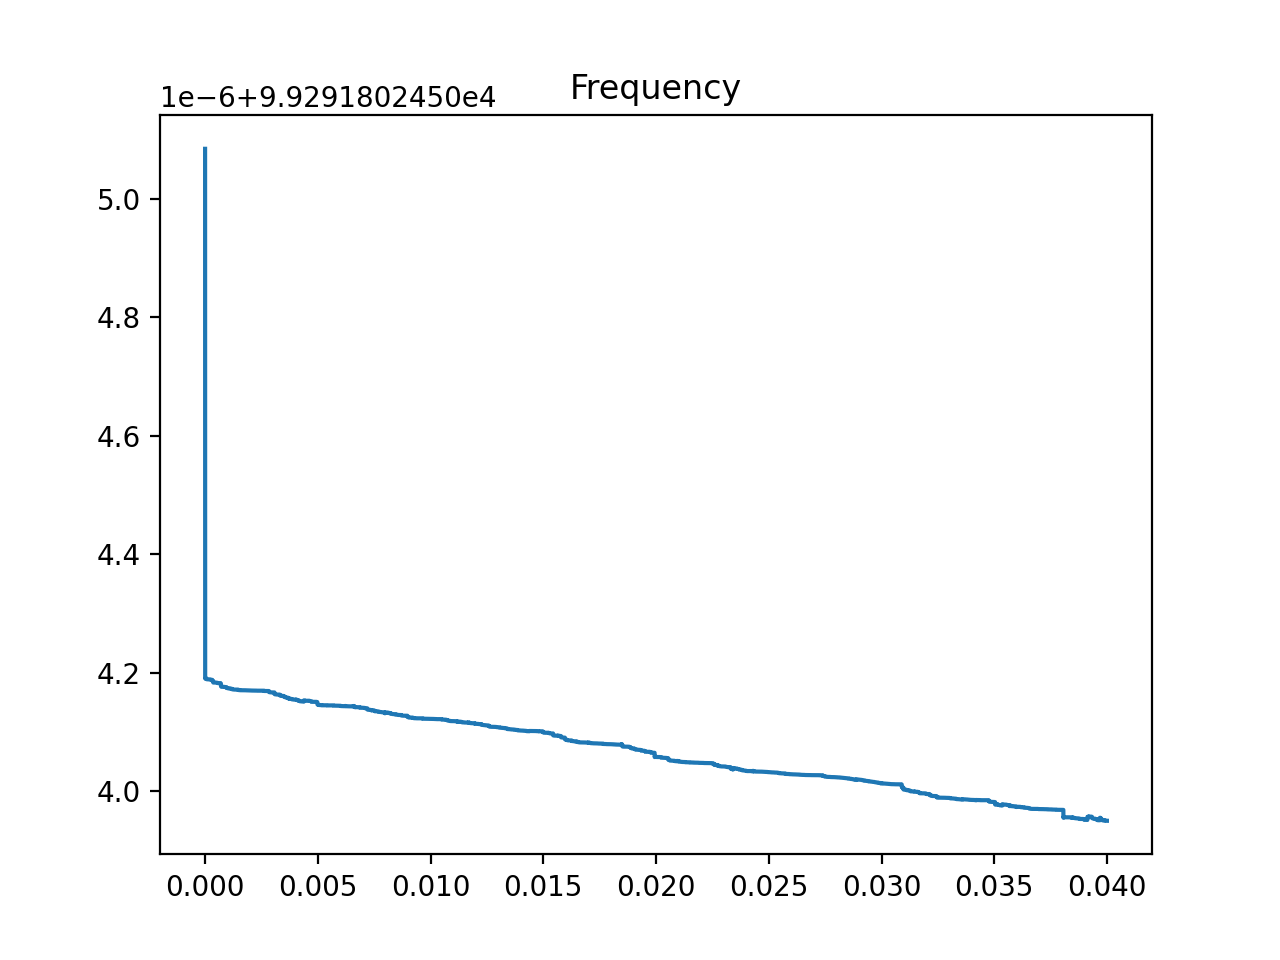

In [85]:
plt.figure()
plt.plot(times, freq)
plt.title('Frequency')
plt.show()

<IPython.core.display.Javascript object>


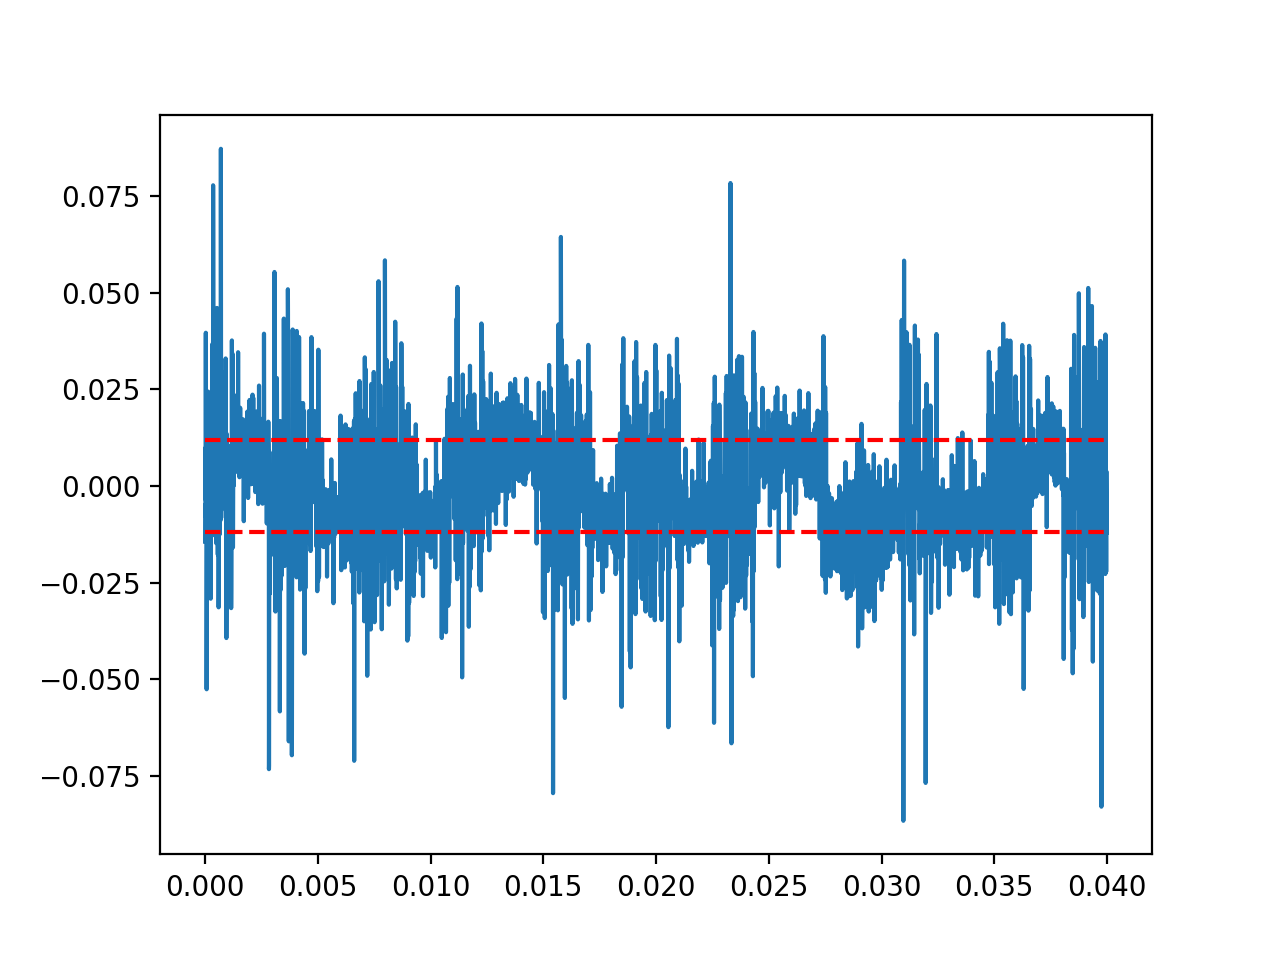

In [86]:
plt.figure()
ax1 = plt.gca()
# ax1.plot(times, (ctrl)*2**16)
ax1.hlines(0.012,times[0],times[-1],linestyles='dashed',colors='r',zorder=3)
ax1.hlines(-0.012,times[0],times[-1],linestyles='dashed',colors='r',zorder=2)
ax1.plot(times, ampl,zorder=1)
plt.show()

<IPython.core.display.Javascript object>


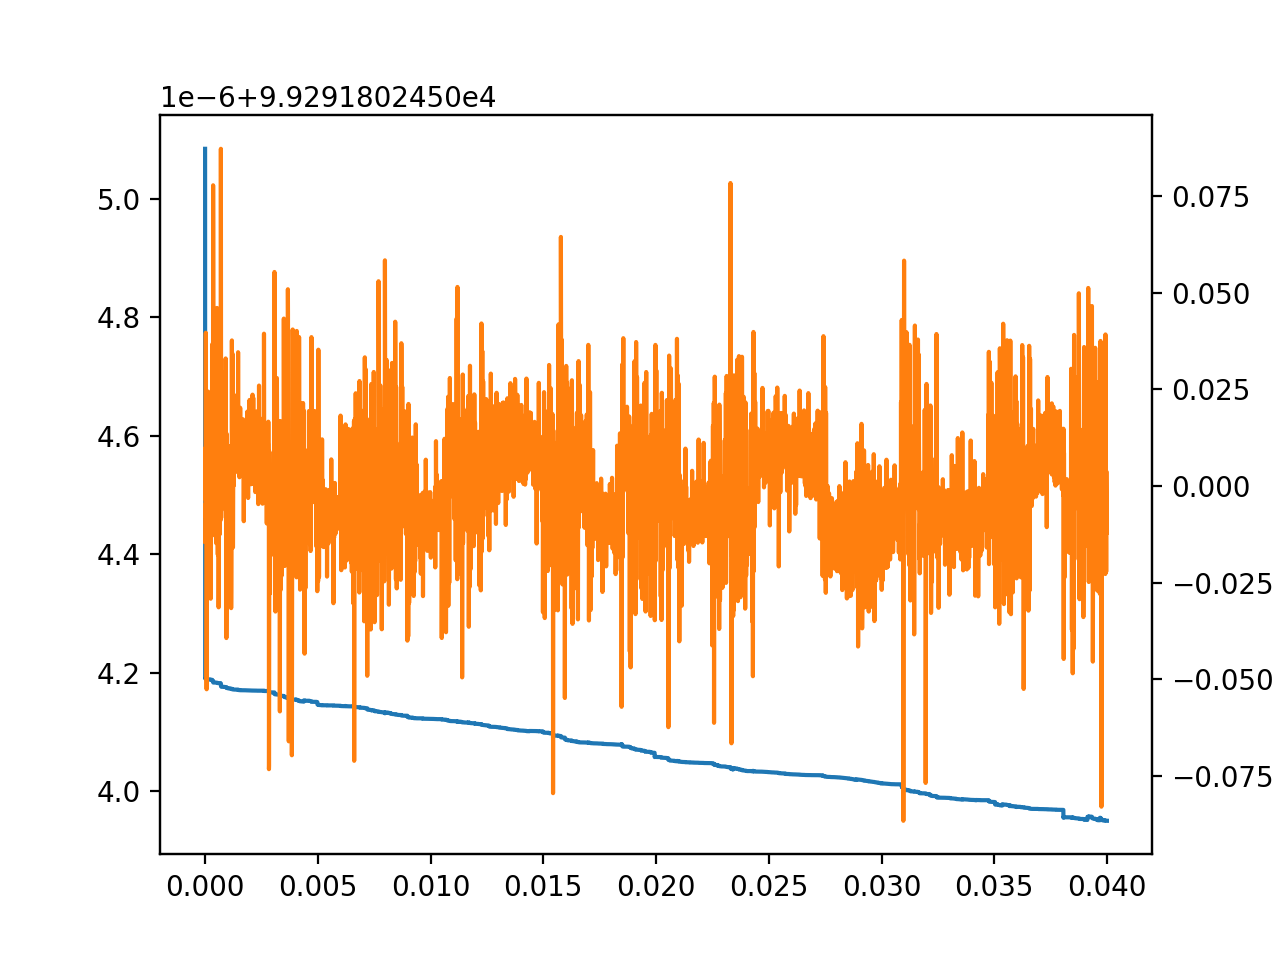

In [87]:
plt.figure()
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(times, freq)
ax2.plot(times, ampl, 'C01')
plt.show()

In [34]:
1/33167

3.0150450749238703e-05

In [18]:
np.pi**2

9.869604401089358